In [1]:
import pandas as pd
import numpy as np
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple
from sklearn.metrics import confusion_matrix

import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict

import scipy as sp

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'


if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

else:
    device = torch.device("mps")

print(device)

/Users/SahajT/Github/Signature-Verification/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps


In [2]:
import pandas as pd
# Train data
train = pd.read_csv('train_data.csv')
train.rename(columns={"1":"label"}, inplace=True)
train["image_real_paths"] = train["image1"].apply(lambda x: f"../sign_data/full/{x}")
train["image_forged_paths"] = train["image2"].apply(lambda x: f"../sign_data/full/{x}")

# Test data
test = pd.read_csv('test_data.csv')
test.rename(columns={"1":"label"}, inplace=True)
test["image_real_paths"] = test["image1"].apply(lambda x: f"../sign_data/full/{x}")
test["image_forged_paths"] = test["image2"].apply(lambda x: f"../sign_data/full/{x}")

In [3]:
train["label"].value_counts(normalize=True)

label
1    0.54304
0    0.45696
Name: proportion, dtype: float64

In [4]:
test["label"].value_counts(normalize=True)

label
1    0.543085
0    0.456915
Name: proportion, dtype: float64

In [5]:
def get_score(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    return score

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(42)

In [6]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    ''' img - signature image
        canvas_size - size of the canvas img will be placed on. Should be greater than img size
        img_size - size to rescale signature
        input_size - crop the center of image
    '''
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped

In [7]:
def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
     # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]
    
     # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image

In [8]:
def remove_background(img: np.ndarray) -> np.ndarray:
    
        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img

In [9]:
def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)
    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]

In [10]:
def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

In [11]:
def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    #plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray')
    plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [12]:
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)

observation = train.iloc[5]
img1 = load_signature(observation["image_real_paths"])
img2 = load_signature(observation["image_forged_paths"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

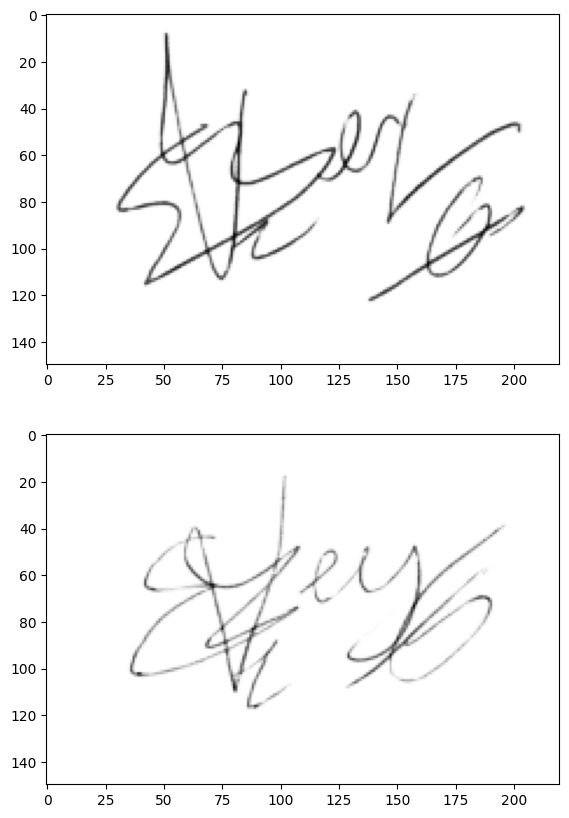

In [13]:
f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

In [14]:
class SignatureDataset(Dataset):
    
    def __init__(self, df, canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["image_real_paths"].values
        self.forged_file_names = df["image_forged_paths"].values
        self.labels = df["label"].values
        self.dim = dim
        self.canvas_size=canvas_size

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]
        
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return torch.tensor(img1), torch.tensor(img2), label.float()

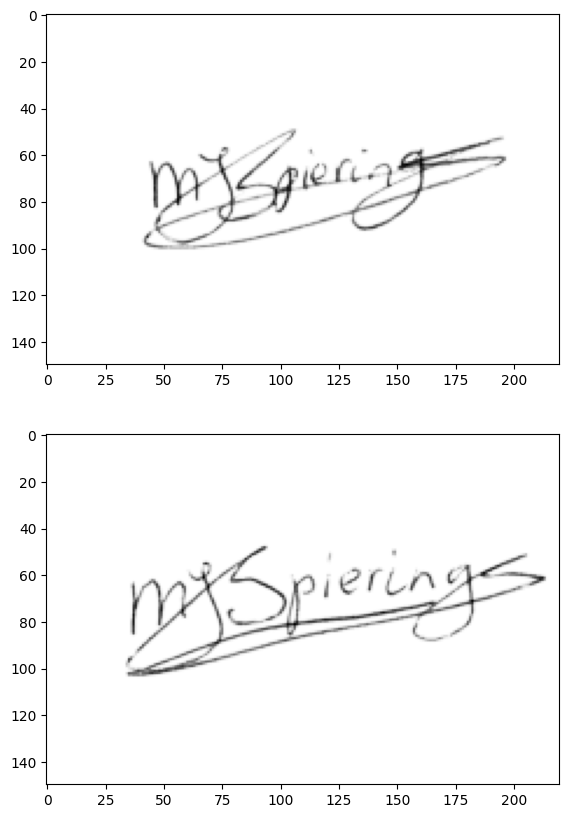

In [15]:
train_dataset = SignatureDataset(train, canvas_size, input_size)
img1, img2, _ = train_dataset[1]

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)

In [16]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(F.normalize(output1), F.normalize(output2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [17]:
class SigNet(nn.Module):
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))
    
    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2

def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('mish', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('mish', nn.Mish()),
    ]))

class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.model = SigNet()
        state_dict, _, _ = torch.load("../signet.pth")
        self.model.load_state_dict(state_dict)
        
        self.probs = nn.Linear(4, 1)
        self.projection2d = nn.Linear(self.model.feature_space_size, 2)
    
    def forward_once(self, img):
        x = self.model.forward_once(img)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        # forward pass of input 1
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        embedding1 = self.forward_once(img1)
        # forward pass of input 2
        embedding2 = self.forward_once(img2)
        
            #print("Project embeddings into 2d space")
        embedding1 = self.projection2d(embedding1)
        embedding2 = self.projection2d(embedding2)
            # Classification
        output = torch.cat([embedding1, embedding2], dim=1)
        output= self.probs(output)
        
        return embedding1, embedding2, output

In [18]:
class AverageMeter(object):
    """Calculating average value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
def train_function(fold, train_loader, model, criterions, optimizer, epoch, scheduler, device):
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    
    global_step = 0
    for step, (img1, img2, labels) in enumerate(train_loader):
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        out1, out2, preds = model(img1, img2)
        loss1 = criterions[0](out1, out2, labels)
        loss2 = criterions[1](preds.squeeze(1), labels)
        loss = (loss1 + loss2) / 2
        
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1000)
        
        if (step + 1) % 1 == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
            
        if step % 100 == 0 or step == (len(train_loader)-1):
            print(f'Epoch: [{epoch}][{step}/{len(train_loader)}] ', end='')
            print(f'Loss: {losses.val:.4f}({losses.avg:.4f}) ', end='')
            print(f'Grad: {grad_norm:.4f} ', end='')
            if scheduler:
                print(f'LR: {scheduler.get_last_lr()[0]:.6f}  ')
            else:
                print(f'LR: 1e-3')
    return losses.avg

In [20]:
seed_torch(42)

train_dataset = SignatureDataset(train, (952, 1360), (256, 256))

train_loader = DataLoader(train_dataset,
                              batch_size=32, 
                              shuffle=True)

def get_scheduler(optimizer):
    scheduler = CosineAnnealingLR(optimizer, **{
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    })
    return scheduler

model = SiameseModel()
model.to(device)

SiameseModel(
  (model): SigNet(
    (conv_layers): Sequential(
      (conv1): Sequential(
        (conv): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mish): Mish()
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Sequential(
        (conv): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mish): Mish()
      )
      (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Sequential(
        (conv): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mish): Mish()
      )
      (conv4): Sequent

In [22]:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
try:
    scheduler = get_scheduler(optimizer)
except:
    print('Learning scheduler is not used')

contrastive = ContrastiveLoss() # Contrastive loss
binary_cross = nn.BCEWithLogitsLoss() # Binary cross entropy
best_score = 0.
best_loss = np.inf

for epoch in range(20):
    avg_loss = train_function(train, train_loader, model, [contrastive, binary_cross], optimizer, epoch, scheduler, device)
    scheduler.step()
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({'model': model.state_dict()}, 'best_model_21.pt')

Epoch: [0][0/726] Loss: 0.7075(0.7075) Grad: 40.1924 LR: 0.001000  
Epoch: [0][100/726] Loss: 0.4477(0.6341) Grad: 0.9742 LR: 0.001000  
Epoch: [0][200/726] Loss: 0.4252(0.5327) Grad: 1.3435 LR: 0.001000  
Epoch: [0][300/726] Loss: 0.1678(0.4459) Grad: 0.9223 LR: 0.001000  
Epoch: [0][400/726] Loss: 0.0676(0.3828) Grad: 0.5818 LR: 0.001000  
Epoch: [0][500/726] Loss: 0.0541(0.3323) Grad: 0.5197 LR: 0.001000  
Epoch: [0][600/726] Loss: 0.1216(0.2945) Grad: 1.7502 LR: 0.001000  
Epoch: [0][700/726] Loss: 0.0940(0.2671) Grad: 1.1005 LR: 0.001000  
Epoch: [0][725/726] Loss: 0.7541(0.2612) Grad: 5.5537 LR: 0.001000  
Epoch: [1][0/726] Loss: 0.0956(0.0956) Grad: 1.2343 LR: 0.000855  
Epoch: [1][100/726] Loss: 0.3669(0.0926) Grad: 1.5239 LR: 0.000855  
Epoch: [1][200/726] Loss: 0.1208(0.1019) Grad: 1.0923 LR: 0.000855  
Epoch: [1][300/726] Loss: 0.1009(0.0853) Grad: 1.0667 LR: 0.000855  
Epoch: [1][400/726] Loss: 0.0104(0.0707) Grad: 0.1805 LR: 0.000855  
Epoch: [1][500/726] Loss: 0.0178(0.06

In [35]:
seed_torch(42)
model = SiameseModel()
model.load_state_dict(torch.load('verify-backend/best_model_21.pt')['model'])


test_dataset = SignatureDataset(test, (952, 1360), (256, 256))

test_loader = DataLoader(test_dataset,
                              batch_size=1, 
                              shuffle=True)

counter = 0 
label_dict = {0.0:'Forged', 1.0:'Genuine'}
#CFG.projection2d=True
model.eval()

SiameseModel(
  (model): SigNet(
    (conv_layers): Sequential(
      (conv1): Sequential(
        (conv): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mish): Mish()
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Sequential(
        (conv): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mish): Mish()
      )
      (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Sequential(
        (conv): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mish): Mish()
      )
      (conv4): Sequent

In [39]:
true_labels = []
predicted_labels = []

for i, data in enumerate(test_loader, 0):
    img1, img2, label = data
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    confidence = confidence.sigmoid().detach().to('cpu')
    # Consider as 'genuine' if confidence > 0.5
    predicted = 1 if confidence.item() > 0.5 else 0
    true_labels.append(label.item())
    predicted_labels.append(predicted)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[1, 0])  # Assuming 1 for genuine and 0 for forged
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[2521    0]
 [   1 2120]]


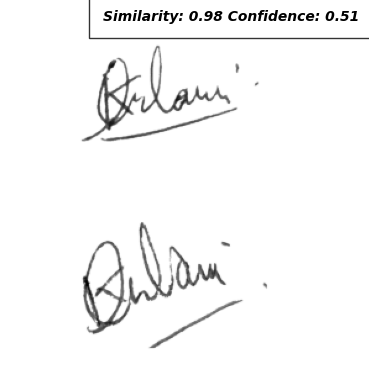

In [49]:
def fetch_img(real_file_path, forged_file_path):
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, (952, 1360), (256, 256))
        img2 = preprocess_signature(img2, (952, 1360), (256, 256))
        
        return torch.tensor(img1), torch.tensor(img2)

img1_tensor, img2_tensor = fetch_img("../signatures/kg1.jpg", "../signatures/kg2.jpg")
#img1_tensor, img2_tensor = fetch_img("../signatures/hb1.png", "../signatures/hb1.png")

# Load model and set to evaluation mode
model.eval()
model.to('cpu')  # Ensure model is on the correct device

# Inference
with torch.no_grad():
    op1, op2, confidence = model(img1_tensor, img2_tensor)
    confidence = torch.sigmoid(confidence).item()  # Convert output to probability
    cos_sim = F.cosine_similarity(op1, op2).item()  # Calculate cosine similarity

# Visualization of results
concatenated = torch.cat((img1_tensor, img2_tensor), 0)
imshow(torchvision.utils.make_grid(concatenated), f'Similarity: {cos_sim:.2f} Confidence: {confidence:.2f}')


## 